In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from torchvision import datasets, models
from torch.utils.data import Subset
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
config = {"batch_size": 64, "epochs": 10, "learning_rate": 0.01}

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=config["batch_size"], shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=config["batch_size"], shuffle=False
)

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def EMA(new, alpha=0.99, old=None):
    if old is None:
        return new
    else:
        return old * alpha + (1 - alpha) * new


def loss_fn(x, y):
    # L2 normalization
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)


class MLP(nn.Module):
    def __init__(self, input_dim=512) -> None:  # Изменено на 512
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
        )

    def forward(self, x):
        return self.net(x)


class TargetModel(nn.Module):
    def __init__(self) -> None:
        super(TargetModel, self).__init__()
        self.encoder = torchvision.models.resnet18(weights=None)  # Используем ResNet-18
        self.encoder.conv1 = torch.nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.encoder.fc = nn.Identity()  # Убираем последний полносвязный слой
        self.encoder.maxpool = torch.nn.Identity()  # Убираем maxpool слой

        self.represent = MLP()  # Используем MLP для проекции

    def forward(self, x):
        x = self.encoder(x)
        x = self.represent(x)  # Передаем через MLP
        return x


class OnlineModel(nn.Module):
    def __init__(self) -> None:
        super(OnlineModel, self).__init__()
        self.encoder = torchvision.models.resnet18(weights=None)  # Используем ResNet-18
        self.encoder.conv1 = torch.nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.encoder.fc = nn.Identity()  # Убираем последний полносвязный слой
        self.encoder.maxpool = torch.nn.Identity()  # Убираем maxpool слой

        self.represent = MLP()  # Используем MLP для проекции

    def forward(self, x):
        x = self.encoder(x)
        x = self.represent(x)  # Передаем через MLP
        return x


class BYOL(nn.Module):
    def __init__(self, moving_average_decay=0.99) -> None:
        super(BYOL, self).__init__()

        self.student_model = OnlineModel()
        self.teacher_model = TargetModel()
        self.moving_average_decay = moving_average_decay
        self.student_predictor = MLP(input_dim=256)

    @torch.no_grad()
    def update_moving_average(self):
        assert self.teacher_model is not None, "Target model has not been created yet"
        for student_params, teacher_params in zip(
            self.student_model.parameters(), self.teacher_model.parameters()
        ):
            old_weight, up_weight = teacher_params.data, student_params.data
            teacher_params.data = EMA(
                old=old_weight, new=up_weight, alpha=self.moving_average_decay
            )

    def forward(self, image1, image2):
        # Проекции студента: спинальные слои + MLP
        student_proj_one = self.student_model(image1)
        student_proj_two = self.student_model(image2)

        # Дополнительный слой MLP для предсказаний
        student_pred_one = self.student_predictor(student_proj_one)
        student_pred_two = self.student_predictor(student_proj_two)

        with torch.no_grad():
            # Модель учителя обрабатывает изображения и делает проекции
            teacher_proj_one = self.teacher_model(image1).detach_()
            teacher_proj_two = self.teacher_model(image2).detach_()

        # Вычисление потерь
        loss_one = loss_fn(student_pred_one, teacher_proj_one)
        loss_two = loss_fn(student_pred_two, teacher_proj_two)

        return (loss_one + loss_two).mean()

In [5]:
torch.cuda.empty_cache()

In [6]:
model = OnlineModel().encoder
model.load_state_dict(torch.load("feature_extractor_19"))
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

C:\Users\dronp\AppData\Local\Temp\ipykernel_9512\2715423706.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("feature_extractor_19"))


#### 100% размеченной выборки

In [7]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    val_loss /= len(dataloader)
    return val_loss, all_labels, all_preds


# Инициализация для хранения метрик
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

# Тренировка модели
for epoch in range(config["epochs"]):
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Расчет метрик на обучении
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        all_train_labels, all_train_preds, average="weighted"
    )
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Оценка на валидационном наборе
    val_loss, all_labels, all_preds = evaluate(model, testloader)
    val_losses.append(val_loss)

    # Расчет метрик на валидации
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch + 1}/{config['epochs']}], "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

Epoch [1/10], Train Loss: 1.5750, Val Loss: 1.3009
Epoch [2/10], Train Loss: 1.0777, Val Loss: 0.9534
Epoch [3/10], Train Loss: 0.8364, Val Loss: 0.8294
Epoch [4/10], Train Loss: 0.6533, Val Loss: 0.6796
Epoch [5/10], Train Loss: 0.4976, Val Loss: 0.6459
Epoch [6/10], Train Loss: 0.3650, Val Loss: 0.6764
Epoch [7/10], Train Loss: 0.2452, Val Loss: 0.7923
Epoch [8/10], Train Loss: 0.1656, Val Loss: 0.7975
Epoch [9/10], Train Loss: 0.1207, Val Loss: 0.9325
Epoch [10/10], Train Loss: 0.0983, Val Loss: 0.9454


In [8]:
# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    # Средняя потеря
    val_loss /= len(dataloader)

    # Расчет метрик для каждого класса (точность, полнота, F1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(10)
    )

    return val_loss, precision, recall, f1


# После завершения обучения, например, после всех эпох:
model.eval()  # Переводим модель в режим оценки (выключает Dropout, BatchNorm)
val_loss, precision, recall, f1 = evaluate(model, testloader)

# Выводим метрики для каждого класса
print("Metrics for each class:")
for i, class_name in enumerate(class_names):
    print(
        f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}"
    )

Metrics for each class:
airplane - Precision: 0.8485, Recall: 0.8120, F1: 0.8298
automobile - Precision: 0.8898, Recall: 0.9120, F1: 0.9007
bird - Precision: 0.7459, Recall: 0.6900, F1: 0.7169
cat - Precision: 0.5725, Recall: 0.6200, F1: 0.5953
deer - Precision: 0.7106, Recall: 0.8080, F1: 0.7562
dog - Precision: 0.6739, Recall: 0.7110, F1: 0.6920
frog - Precision: 0.8994, Recall: 0.7510, F1: 0.8185
horse - Precision: 0.8465, Recall: 0.8380, F1: 0.8422
ship - Precision: 0.9000, Recall: 0.8820, F1: 0.8909
truck - Precision: 0.8717, Recall: 0.8830, F1: 0.8773


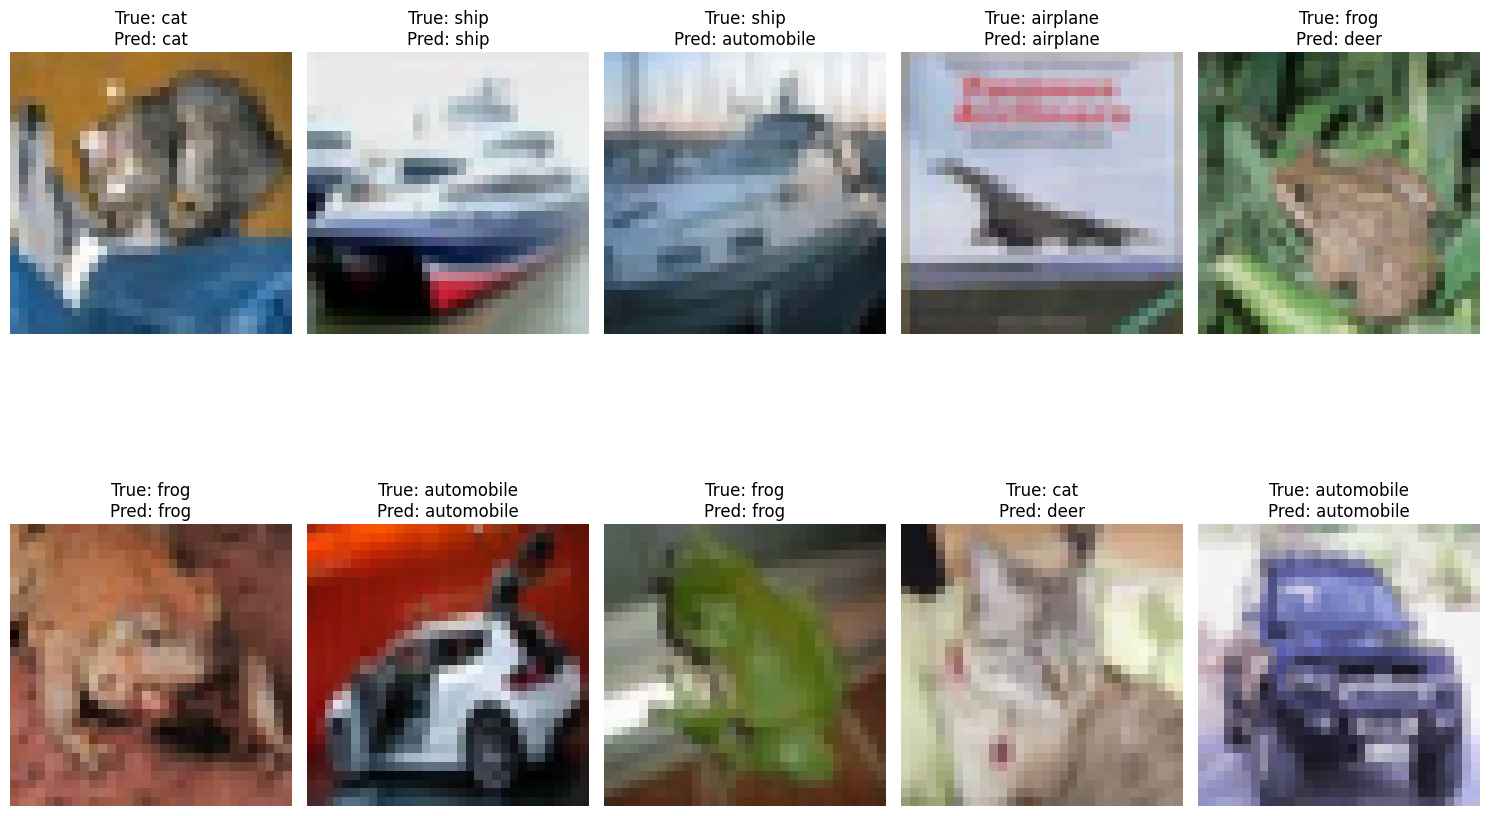

In [9]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))

    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            image = images[i].cpu().numpy().transpose((1, 2, 0))
            image = np.clip(
                image * np.array([0.229, 0.224, 0.225])
                + np.array([0.485, 0.456, 0.406]),
                0,
                1,
            )
            label = class_names[labels[i].item()]
            pred = class_names[preds[i].item()]

            plt.subplot(num_images // 5 + 1, 5, images_shown + 1)
            plt.imshow(image)
            plt.title(f"True: {label}\nPred: {pred}")
            plt.axis("off")
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, testloader, num_images=10)

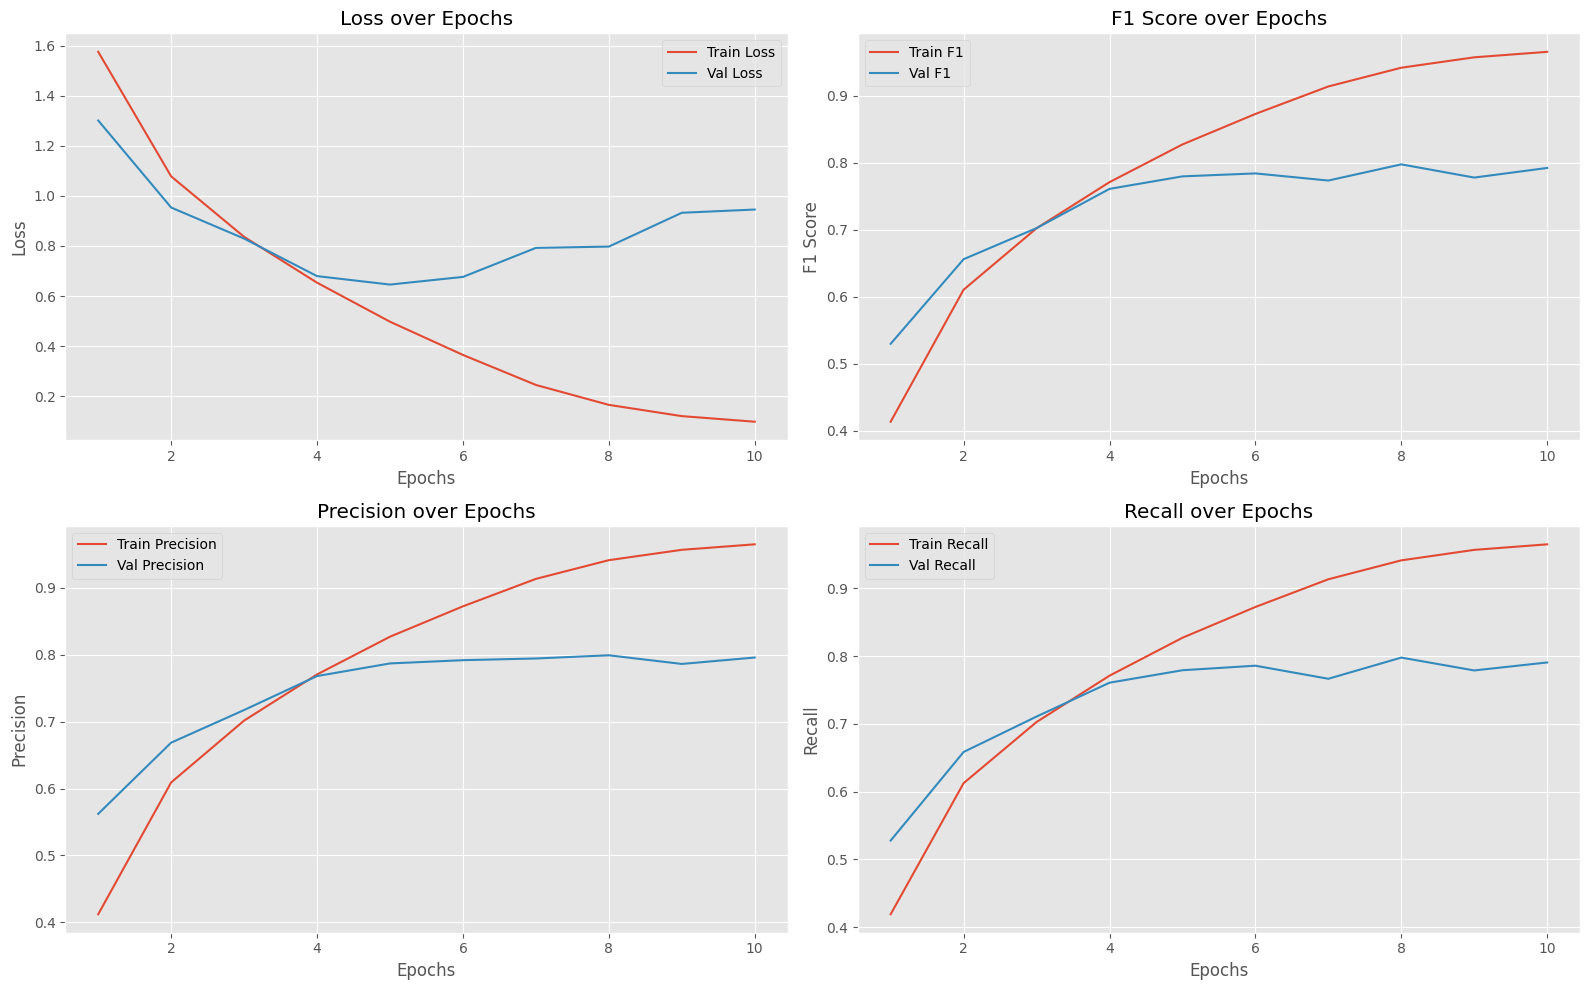

In [10]:
plt.style.use("ggplot")

# Построение графиков
epochs = range(1, config["epochs"] + 1)

plt.figure(figsize=(16, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# График F1-score
plt.subplot(2, 2, 2)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()

# График Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()

# График Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

#### 50% размеченной выборки

In [11]:
train_size = len(trainset) // 2
train_indices = np.random.choice(len(trainset), train_size, replace=False)
train_subset = Subset(trainset, train_indices)

test_size = len(testset) // 2
test_indices = np.random.choice(len(testset), test_size, replace=False)
test_subset = Subset(testset, test_indices)

trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=config["batch_size"], shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_subset, batch_size=config["batch_size"], shuffle=False
)

In [12]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    val_loss /= len(dataloader)
    return val_loss, all_labels, all_preds


# Инициализация для хранения метрик
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

# Тренировка модели
for epoch in range(config["epochs"]):
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Расчет метрик на обучении
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        all_train_labels, all_train_preds, average="weighted"
    )
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Оценка на валидационном наборе
    val_loss, all_labels, all_preds = evaluate(model, testloader)
    val_losses.append(val_loss)

    # Расчет метрик на валидации
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch + 1}/{config['epochs']}], "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

Epoch [1/10], Train Loss: 0.0731, Val Loss: 1.0924
Epoch [2/10], Train Loss: 0.0476, Val Loss: 1.0810
Epoch [3/10], Train Loss: 0.0508, Val Loss: 1.2119
Epoch [4/10], Train Loss: 0.0467, Val Loss: 1.1471
Epoch [5/10], Train Loss: 0.0527, Val Loss: 1.0413
Epoch [6/10], Train Loss: 0.0471, Val Loss: 1.0658
Epoch [7/10], Train Loss: 0.0374, Val Loss: 1.0672
Epoch [8/10], Train Loss: 0.0392, Val Loss: 1.0920
Epoch [9/10], Train Loss: 0.0358, Val Loss: 1.2609
Epoch [10/10], Train Loss: 0.0377, Val Loss: 1.2433


In [13]:
# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    # Средняя потеря
    val_loss /= len(dataloader)

    # Расчет метрик для каждого класса (точность, полнота, F1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(10)
    )

    return val_loss, precision, recall, f1


# После завершения обучения, например, после всех эпох:
model.eval()  # Переводим модель в режим оценки (выключает Dropout, BatchNorm)
val_loss, precision, recall, f1 = evaluate(model, testloader)

# Выводим метрики для каждого класса
print("Metrics for each class:")
for i, class_name in enumerate(class_names):
    print(
        f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}"
    )

Metrics for each class:
airplane - Precision: 0.8165, Recall: 0.7984, F1: 0.8073
automobile - Precision: 0.9414, Recall: 0.8460, F1: 0.8912
bird - Precision: 0.7120, Recall: 0.6899, F1: 0.7008
cat - Precision: 0.6335, Recall: 0.5817, F1: 0.6065
deer - Precision: 0.6061, Recall: 0.8403, F1: 0.7042
dog - Precision: 0.7333, Recall: 0.6086, F1: 0.6652
frog - Precision: 0.8750, Recall: 0.7626, F1: 0.8150
horse - Precision: 0.8089, Recall: 0.8281, F1: 0.8184
ship - Precision: 0.8639, Recall: 0.9104, F1: 0.8865
truck - Precision: 0.8141, Recall: 0.8985, F1: 0.8542


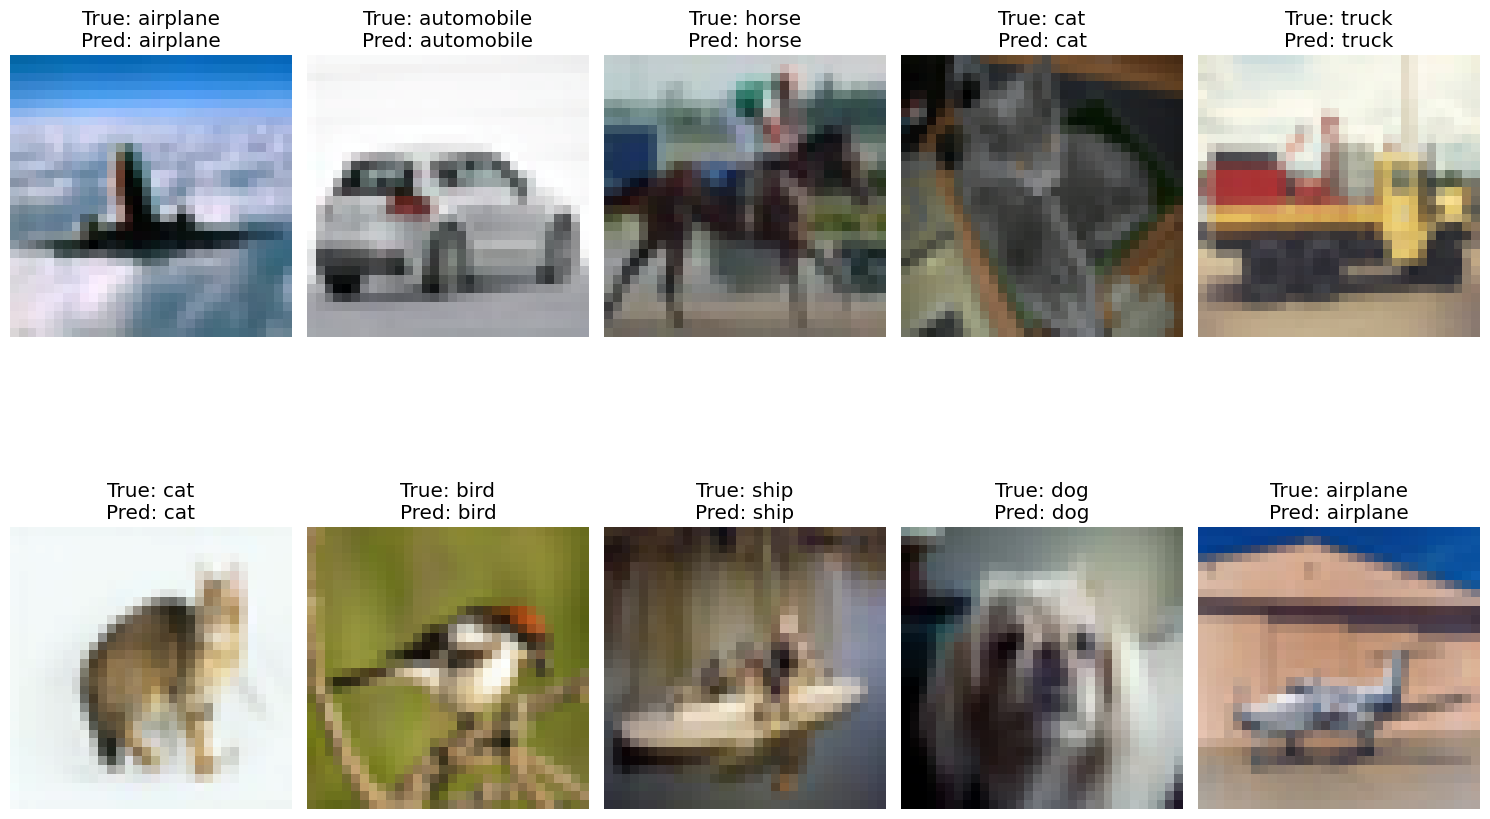

In [14]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))

    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            image = images[i].cpu().numpy().transpose((1, 2, 0))
            image = np.clip(
                image * np.array([0.229, 0.224, 0.225])
                + np.array([0.485, 0.456, 0.406]),
                0,
                1,
            )
            label = class_names[labels[i].item()]
            pred = class_names[preds[i].item()]

            plt.subplot(num_images // 5 + 1, 5, images_shown + 1)
            plt.imshow(image)
            plt.title(f"True: {label}\nPred: {pred}")
            plt.axis("off")
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, testloader, num_images=10)

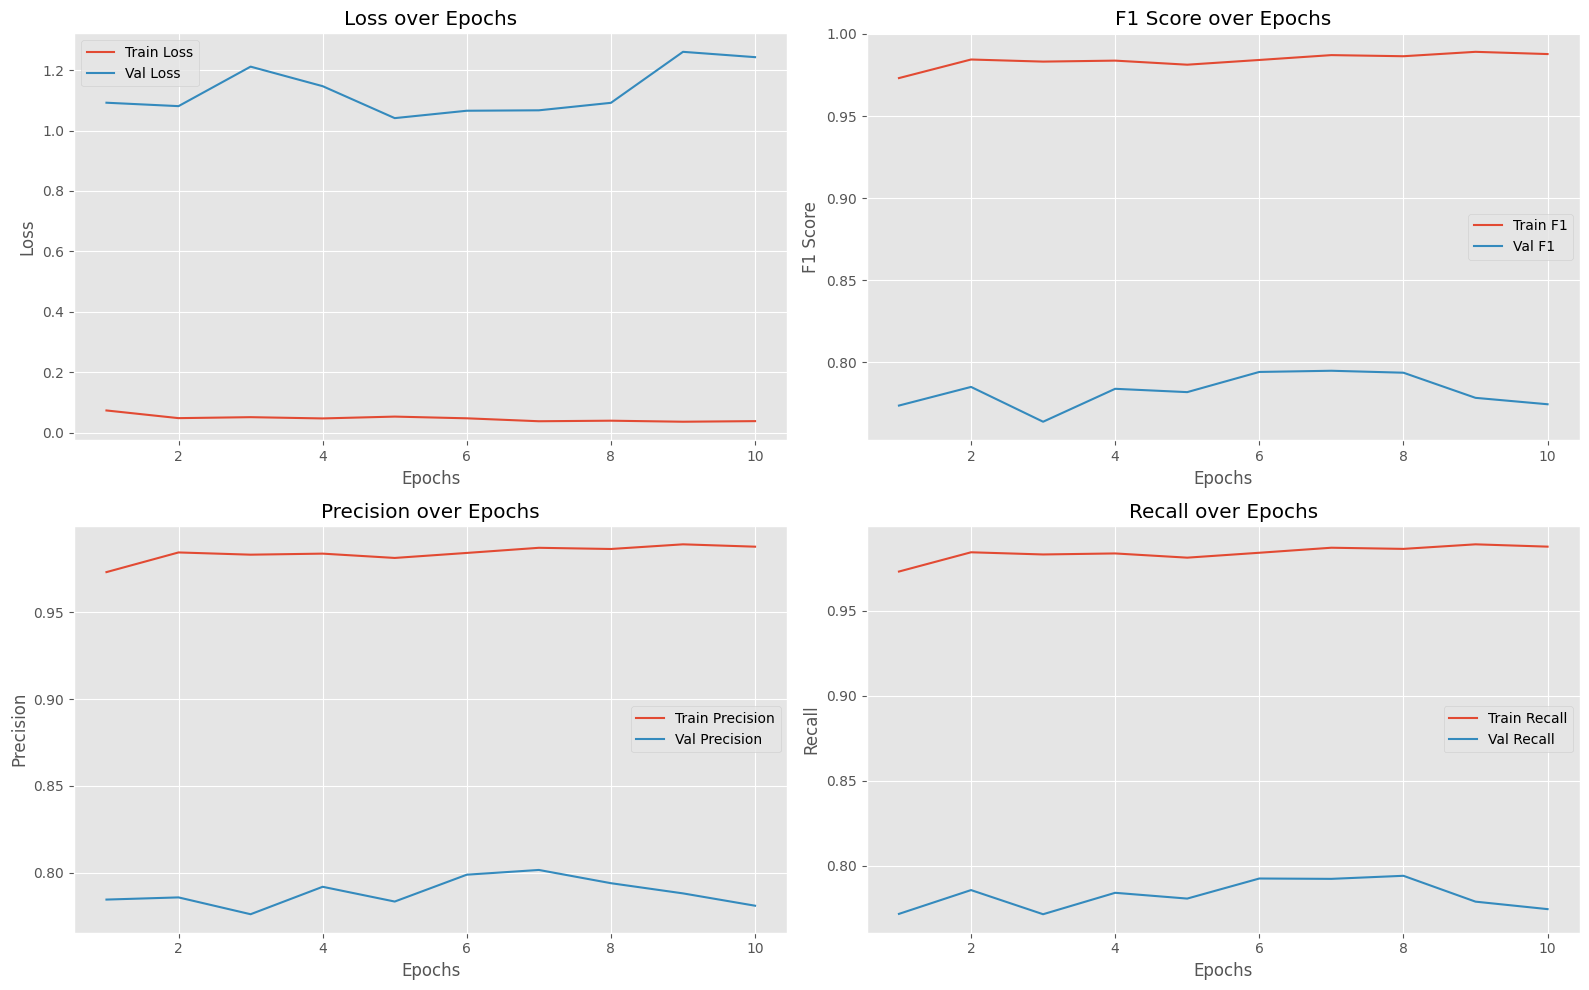

In [15]:
plt.style.use("ggplot")

# Построение графиков
epochs = range(1, config["epochs"] + 1)

plt.figure(figsize=(16, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# График F1-score
plt.subplot(2, 2, 2)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()

# График Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()

# График Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

#### 10% размеченной выборки

In [16]:
train_size = len(trainset) // 10
train_indices = np.random.choice(len(trainset), train_size, replace=False)
train_subset = Subset(trainset, train_indices)

test_size = len(testset) // 10
test_indices = np.random.choice(len(testset), test_size, replace=False)
test_subset = Subset(testset, test_indices)

trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=config["batch_size"], shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_subset, batch_size=config["batch_size"], shuffle=False
)

In [17]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    val_loss /= len(dataloader)
    return val_loss, all_labels, all_preds


# Инициализация для хранения метрик
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

# Тренировка модели
for epoch in range(config["epochs"]):
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Расчет метрик на обучении
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        all_train_labels, all_train_preds, average="weighted"
    )
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Оценка на валидационном наборе
    val_loss, all_labels, all_preds = evaluate(model, testloader)
    val_losses.append(val_loss)

    # Расчет метрик на валидации
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch + 1}/{config['epochs']}], "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

Epoch [1/10], Train Loss: 0.1776, Val Loss: 0.9475
Epoch [2/10], Train Loss: 0.0589, Val Loss: 0.9676
Epoch [3/10], Train Loss: 0.0494, Val Loss: 0.9953
Epoch [4/10], Train Loss: 0.0689, Val Loss: 0.9766
Epoch [5/10], Train Loss: 0.0105, Val Loss: 0.9936
Epoch [6/10], Train Loss: 0.0023, Val Loss: 1.0469
Epoch [7/10], Train Loss: 0.0015, Val Loss: 1.0580
Epoch [8/10], Train Loss: 0.0008, Val Loss: 1.0633
Epoch [9/10], Train Loss: 0.0053, Val Loss: 1.0825
Epoch [10/10], Train Loss: 0.0735, Val Loss: 1.3603


In [18]:
# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    # Средняя потеря
    val_loss /= len(dataloader)

    # Расчет метрик для каждого класса (точность, полнота, F1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=range(10)
    )

    return val_loss, precision, recall, f1


# После завершения обучения, например, после всех эпох:
model.eval()  # Переводим модель в режим оценки (выключает Dropout, BatchNorm)
val_loss, precision, recall, f1 = evaluate(model, testloader)

# Выводим метрики для каждого класса
print("Metrics for each class:")
for i, class_name in enumerate(class_names):
    print(
        f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}"
    )

Metrics for each class:
airplane - Precision: 0.7414, Recall: 0.8776, F1: 0.8037
automobile - Precision: 0.7557, Recall: 0.9612, F1: 0.8462
bird - Precision: 0.7738, Recall: 0.6500, F1: 0.7065
cat - Precision: 0.6875, Recall: 0.5500, F1: 0.6111
deer - Precision: 0.8125, Recall: 0.6132, F1: 0.6989
dog - Precision: 0.7273, Recall: 0.6667, F1: 0.6957
frog - Precision: 0.7168, Recall: 0.8438, F1: 0.7751
horse - Precision: 0.7040, Recall: 0.8800, F1: 0.7822
ship - Precision: 0.8242, Recall: 0.8333, F1: 0.8287
truck - Precision: 0.9259, Recall: 0.7576, F1: 0.8333


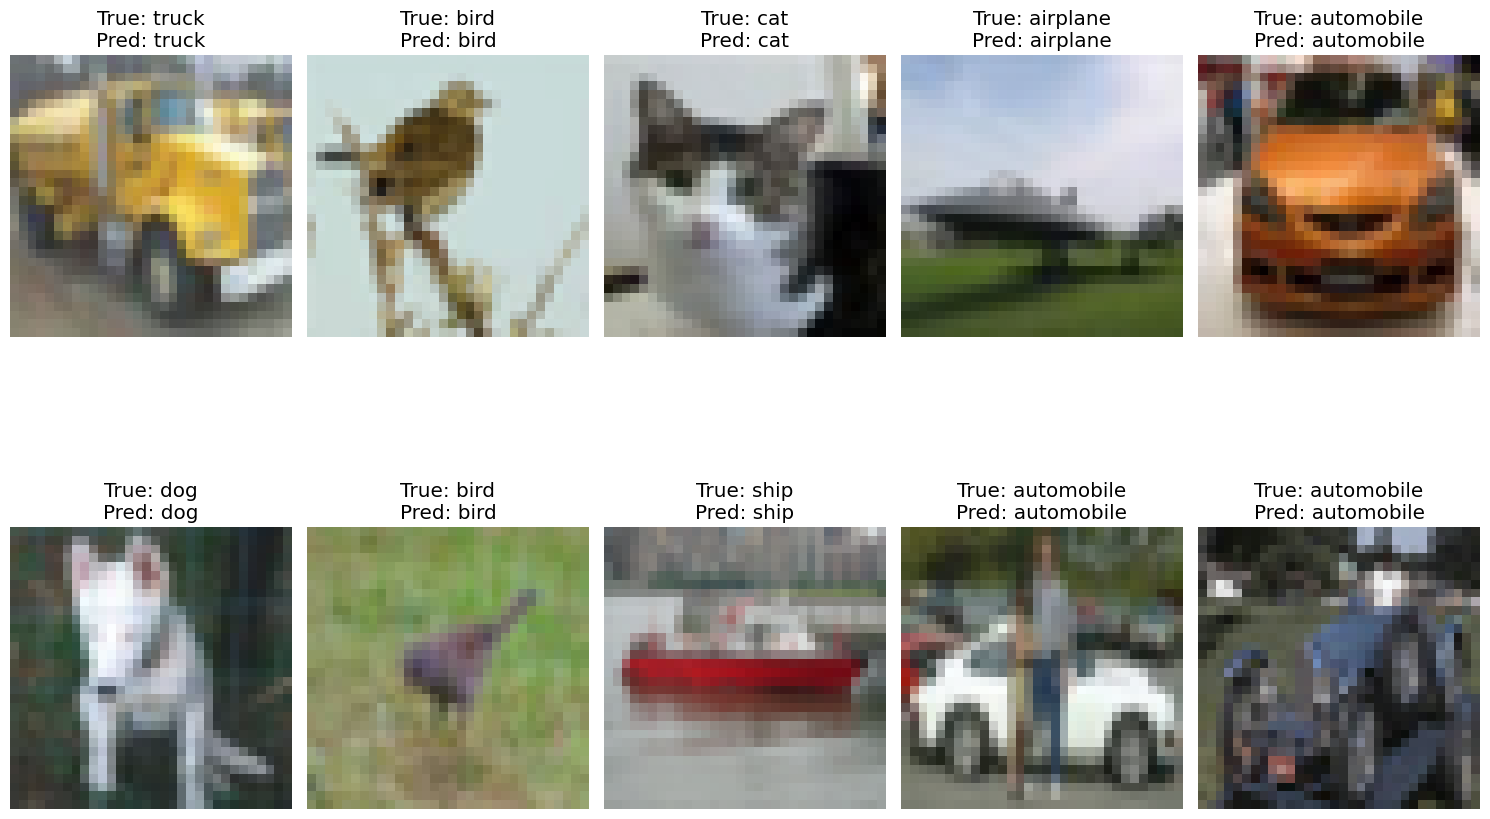

In [19]:
@torch.no_grad()
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))

    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            image = images[i].cpu().numpy().transpose((1, 2, 0))
            image = np.clip(
                image * np.array([0.229, 0.224, 0.225])
                + np.array([0.485, 0.456, 0.406]),
                0,
                1,
            )
            label = class_names[labels[i].item()]
            pred = class_names[preds[i].item()]

            plt.subplot(num_images // 5 + 1, 5, images_shown + 1)
            plt.imshow(image)
            plt.title(f"True: {label}\nPred: {pred}")
            plt.axis("off")
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, testloader, num_images=10)

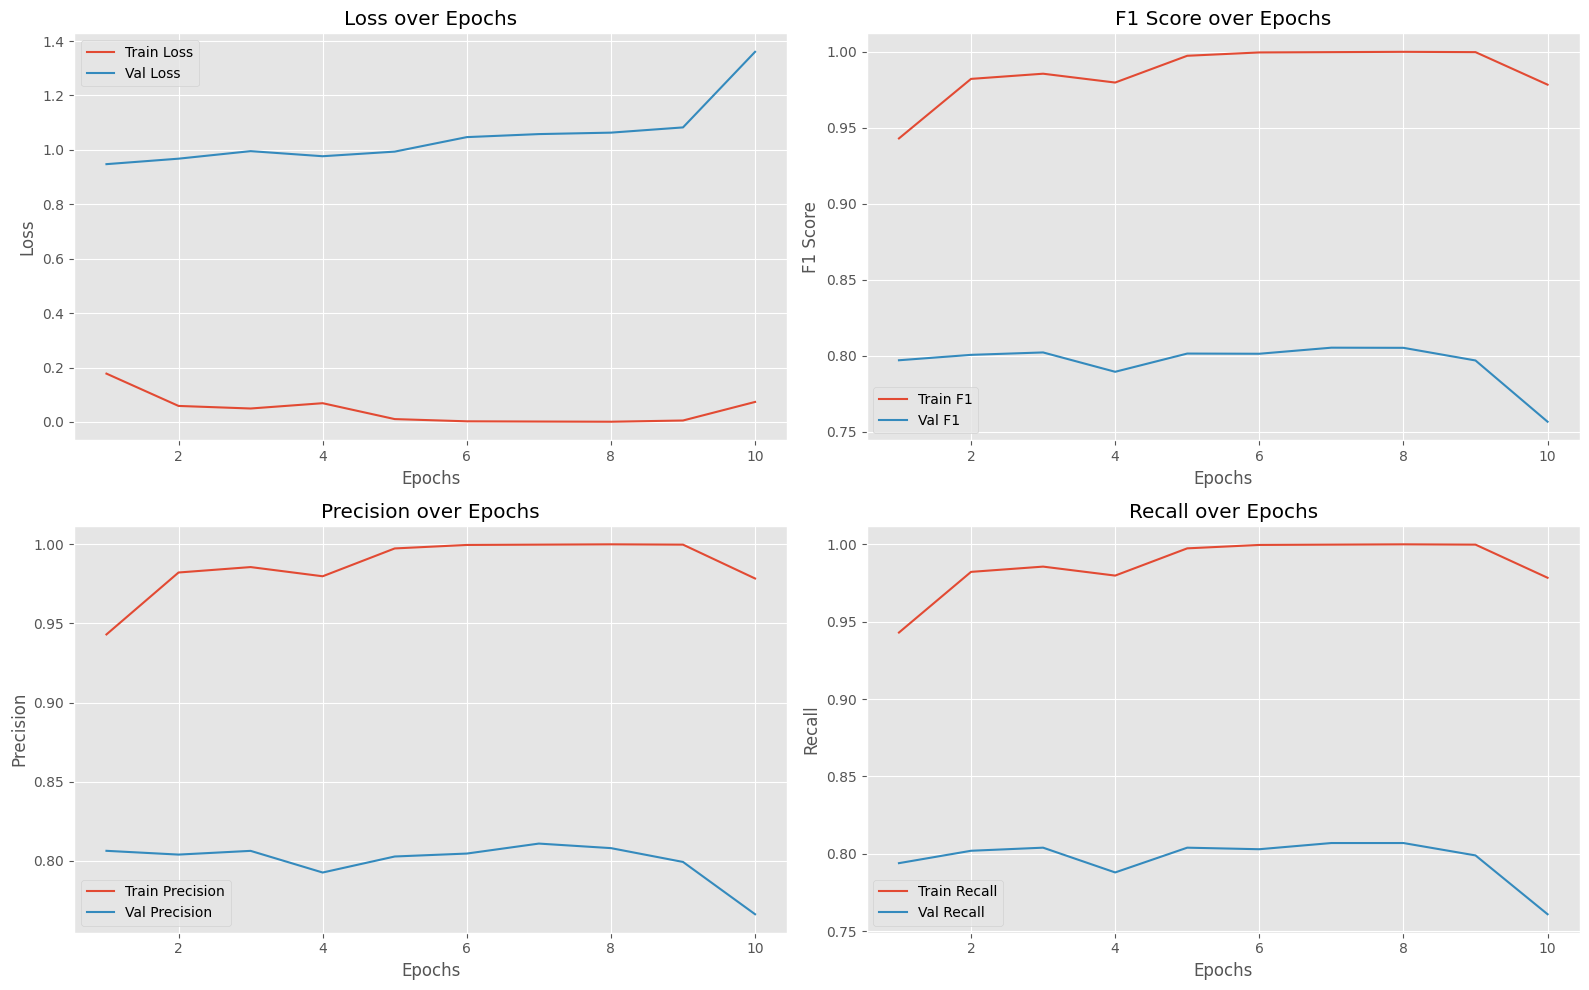

In [20]:
plt.style.use("ggplot")

# Построение графиков
epochs = range(1, config["epochs"] + 1)

plt.figure(figsize=(16, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# График F1-score
plt.subplot(2, 2, 2)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()

# График Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()

# График Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall over Epochs")
plt.legend()

plt.tight_layout()
plt.show()